In [1]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x
# def encoder_block(inputs,num_filters):
#   x=conv_block(inputs,num_filters)
#   p=MaxPool2D((2,2))(x)
#   return x,p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_resnet50_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = resnet50.get_layer("input_1").output           ## (512 x 512)
    s2= resnet50.get_layer("conv1_relu").output        ## (256 x 256)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    return model

if __name__ == "__main__":
    input_shape = (512, 512, 3)
    model = build_resnet50_unet(input_shape)
    model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "ResNet50_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                    

In [ ]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])
model.summary()

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 11.8 MB/s 


In [ ]:
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from scipy.io import loadmat
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import Xception
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
# import tensorflow_addons as tfa
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
train_path = '/content/drive/MyDrive/PennFudanPed/PNGImages'
test_path = '/content/drive/MyDrive/PennFudanPed/dataset_ped/test'
validation_path = '/content/drive/MyDrive/PennFudanPed/dataset_ped/validation'

In [ ]:
# creating a empty list and iterating over every files in image folder and converting them into array and appending them in the created list.
train_images = []
for filename in sorted(os.listdir(train_path)):
    train_image_fullpath = os.path.join(train_path, filename)
    train_img = load_img(train_image_fullpath, target_size=(512,512)) #default input size of the vgg models = (224,224)
    train_img_arr = img_to_array(train_img)
    train_images.append(train_img_arr)

# Converting list into numpy arrays
train_images = np.array(train_images)

In [ ]:
# creating a empty list and iterating over every files in image folder and converting them into array and appending them in the created list.
val_images = []
for filename in sorted(os.listdir(validation_path)):
    val_image_fullpath = os.path.join(validation_path, filename)
    val_img = load_img(val_image_fullpath, target_size=(512,512)) #default input size of the vgg models = (224,224)
    val_img_arr = img_to_array(val_img)
    val_images.append(val_img_arr)
  
# Converting list into numpy arrays
val_images = np.array(val_images)

In [ ]:
# creating a empty list and iterating over every files in image folder and converting them into array and appending them in the created list.

test_images = []
for filename in sorted(os.listdir(test_path)):
    test_image_fullpath = os.path.join(test_path, filename)
    test_img = load_img(test_image_fullpath, target_size=(512,512)) #default input size of the vgg models = (224,224)
    test_img_arr = img_to_array(test_img)
    test_images.append(test_img_arr)

# Converting list into numpy arrays
test_images = np.array(test_images)

In [ ]:
# Paths of train, test and validation bounding box coordinates
train_path1 = '/content/drive/MyDrive/PennFudanPed/mask/all_train'
test_path1 = '/content/drive/MyDrive/PennFudanPed/mask/test'
validation_path1 = '/content/drive/MyDrive/PennFudanPed/mask/validation'

In [ ]:
import cv2

In [ ]:
# creating a empty list and iterating over every files in image folder and converting them into array and appending them in the created list.
train_target_images = []
for filename in sorted(os.listdir(train_path1)):
    train_image_fullpath = os.path.join(train_path1, filename)
    image_bro=cv2.imread(train_image_fullpath)
    image_bro=cv2.resize(image_bro,(512,512),interpolation = cv2.INTER_NEAREST)
    image_bro_gray=cv2.cvtColor(image_bro, cv2.COLOR_BGR2GRAY)
    train_target_images.append(image_bro_gray)

# Converting list into numpy arrays
train_targets = np.array(train_target_images)

In [ ]:
train_targets.shape


(160, 512, 512)

In [ ]:
train_images.shape

(160, 512, 512, 3)

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
image_bro=cv2.imread(train_image_fullpath)
image_bro=cv2.resize(image_bro,(512,512),interpolation = cv2.INTER_NEAREST)
image_bro_gray=cv2.cvtColor(image_bro, cv2.COLOR_BGR2GRAY)
# cv2_imshow(image_bro_gray)

In [ ]:
type(image_bro_gray)

numpy.ndarray

In [ ]:
test_target_images = []
for filename in sorted(os.listdir(test_path1)):
    test_image_fullpath = os.path.join(test_path1, filename)
    image_bro=cv2.imread(test_image_fullpath)
    image_bro=cv2.resize(image_bro,(512,512),interpolation = cv2.INTER_NEAREST)
    image_bro_gray=cv2.cvtColor(image_bro, cv2.COLOR_BGR2GRAY)
    test_target_images.append(image_bro_gray)

# Converting list into numpy arrays
test_targets = np.array(test_target_images)

In [ ]:
# creating a empty list and iterating over every files in image folder and converting them into array and appending them in the created list.
val_target_images = []
for filename in sorted(os.listdir(validation_path1)):
    val_image_fullpath = os.path.join(validation_path1, filename)
    image_bro=cv2.imread(val_image_fullpath)
    image_bro=cv2.resize(image_bro,(512,512),interpolation = cv2.INTER_NEAREST)
    image_bro_gray=cv2.cvtColor(image_bro, cv2.COLOR_BGR2GRAY)
    val_target_images.append(image_bro_gray)
  
# Converting list into numpy arrays
val_targets = np.array(val_target_images)

In [ ]:
train_targets.shape

(160, 512, 512)

In [ ]:
# Train the model for 20 epochs
trained_model = model.fit(train_images, train_targets,
             validation_data=(val_images, val_targets),
             batch_size=4,
             epochs=20,
             shuffle=True,
             verbose=2)

Epoch 1/20
40/40 - 136s - loss: -9.4325e-02 - acc: 0.7870 - val_loss: 1.7464 - val_acc: 0.8926 - 136s/epoch - 3s/step
Epoch 2/20
40/40 - 86s - loss: -8.4158e-01 - acc: 0.8376 - val_loss: 8.2094 - val_acc: 0.3862 - 86s/epoch - 2s/step
Epoch 3/20
40/40 - 86s - loss: -1.1012e+00 - acc: 0.8368 - val_loss: 2.5861 - val_acc: 0.7393 - 86s/epoch - 2s/step
Epoch 4/20
40/40 - 86s - loss: -1.3538e+00 - acc: 0.8459 - val_loss: 0.4946 - val_acc: 0.9015 - 86s/epoch - 2s/step
Epoch 5/20
40/40 - 86s - loss: -1.5261e+00 - acc: 0.8570 - val_loss: 1.3501 - val_acc: 0.8097 - 86s/epoch - 2s/step
Epoch 6/20
40/40 - 86s - loss: -1.6299e+00 - acc: 0.8645 - val_loss: 1.5863 - val_acc: 0.7957 - 86s/epoch - 2s/step
Epoch 7/20
40/40 - 86s - loss: -1.6410e+00 - acc: 0.8601 - val_loss: 3.6634 - val_acc: 0.6332 - 86s/epoch - 2s/step
Epoch 8/20
40/40 - 86s - loss: -1.7438e+00 - acc: 0.8682 - val_loss: 0.1371 - val_acc: 0.9167 - 86s/epoch - 2s/step
Epoch 9/20
40/40 - 86s - loss: -1.8214e+00 - acc: 0.8716 - val_loss: 0

In [ ]:
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/PennFudanPed/model2_resnet50.h5')


In [ ]:
 from tensorflow.keras.models import load_model
 model = load_model('/content/drive/MyDrive/PennFudanPed/model_resnet50.h5')

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# test_img=load_img('/content/drive/MyDrive/PennFudanPed/Test/Screenshot_20220420_160054.jpg',target_size=(512,512,3))
y_pred = model.predict(test_images)

# n = test_targets[0]
# image = cv2.imread('/content/drive/MyDrive/PennFudanPed/Test/FudanPed00011.png')
# cv2.rectangle(image, (n[0],n[1]), (n[2],n[3]), (255,0,0), 2)
# cv2.rectangle(image, (m[0],m[1]), (m[2],m[3]), (0,255,0), 2)
# cv2_imshow(image)
# cv2.waitKey(0)


In [ ]:
m = y_pred[42]

In [ ]:
cv2.imwrite('/content/drive/MyDrive/PennFudanPed/results/TESTING1.jpg', m)

True

In [ ]:

# for i,im in enumerate(y_pred):
#   file_name=str(i+1)+".png"
#   cv2.imwrite('/content/drive/MyDrive/PennFudanPed/results/'+file_name, im)


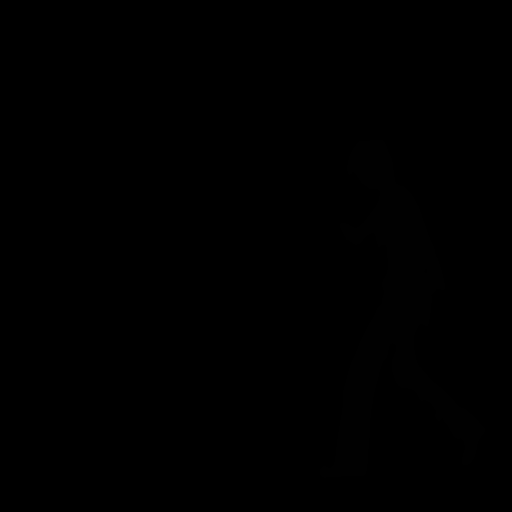

In [ ]:
cv2_imshow(m)


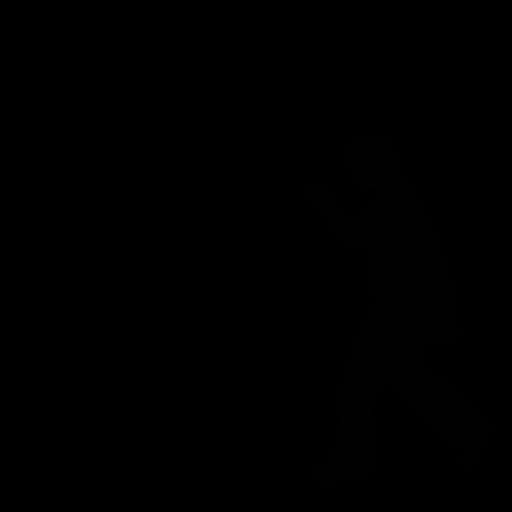

In [ ]:
cv2_imshow(n)

In [ ]:
m

array([[[0.00812665],
        [0.01873561],
        [0.01514672],
        ...,
        [0.00835833],
        [0.02054871],
        [0.04505907]],

       [[0.00453031],
        [0.01123664],
        [0.01259718],
        ...,
        [0.01051349],
        [0.01069788],
        [0.01754806]],

       [[0.0046884 ],
        [0.00911511],
        [0.01051553],
        ...,
        [0.01484132],
        [0.01507732],
        [0.01445534]],

       ...,

       [[0.0070729 ],
        [0.01285768],
        [0.01153299],
        ...,
        [0.00715233],
        [0.00966293],
        [0.01028675]],

       [[0.01153725],
        [0.01133306],
        [0.01060648],
        ...,
        [0.00730867],
        [0.00668081],
        [0.00718489]],

       [[0.01033501],
        [0.02622921],
        [0.01058658],
        ...,
        [0.00877127],
        [0.01252716],
        [0.0187102 ]]], dtype=float32)

In [ ]:
import cv2
cv2.imwrite('/content/drive/MyDrive/PennFudanPed/results/Image.jpg', m)

True